# APTOS 2019 - Multi-Teacher Knowledge Distillation

## Student: MobileNetV3-Small | Teachers: ResNet50 + EfficientNet-B3

**Setup:** Make sure the dataset is attached via '+ Add data' → Search for your dataset

Dataset paths:
- Images: `/kaggle/input/aptos-2019/train_images/`
- CSV: `/kaggle/input/aptos-2019/train.csv`

In [1]:
import os, time, copy, math
import random
import numpy as np
from pathlib import Path
from collections import defaultdict
import gc

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from PIL import Image
from torch.cuda.amp import GradScaler, autocast
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd

print('Torch version:', torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Torch version: 2.8.0+cu126
Device: cuda


## Quick Dataset Verification

Let's verify your APTOS 2019 dataset is properly attached.

In [2]:
# Quick check: List available datasets
import os
print("Available datasets in /kaggle/input/:")
print("="*70)
if os.path.exists('/kaggle/input/datasets/almiraraisa/aptos-2019'):
    for item in os.listdir('/kaggle/input/datasets/almiraraisa/aptos-2019'):
        print(f"  • {item}")
        dataset_path = f'/kaggle/input/{item}'
        if os.path.isdir(dataset_path):
            contents = os.listdir(dataset_path)
            for content in contents[:10]:  # Show first 10 items
                print(f"      - {content}")
            if len(contents) > 10:
                print(f"      ... and {len(contents) - 10} more items")
else:
    print("  ⚠ /kaggle/input directory not found")
    print("  Make sure you're running this in a Kaggle notebook with datasets attached")

print("\n" + "="*70)
print("If you see 'aptos-2019' above, you're good to go!")
print("If not, click '+ Add data' and search for your APTOS 2019 dataset.")
print("="*70)

Available datasets in /kaggle/input/:
  • sample_submission.csv
  • train_images
  • train.csv
  • test.csv
  • test_images

If you see 'aptos-2019' above, you're good to go!
If not, click '+ Add data' and search for your APTOS 2019 dataset.


## Dataset Configuration

Direct paths to your Kaggle dataset - no downloads needed!

In [3]:
# Dataset paths - matches your uploaded Kaggle dataset
DATASET_ROOT = '/kaggle/input/datasets/almiraraisa/aptos-2019'
IMAGE_DIR = f'{DATASET_ROOT}/train_images'
LABEL_CSV = f'{DATASET_ROOT}/train.csv'

print("Dataset Configuration")
print("="*70)

# Verify dataset is attached
if not os.path.exists(DATASET_ROOT):
    raise FileNotFoundError(
        f"Dataset not found: {DATASET_ROOT}\n"
        "Make sure you've attached the 'APTOS 2019' dataset via '+ Add data' in Kaggle\n"
        "Search for your dataset and add it to the notebook."
    )

if not os.path.exists(IMAGE_DIR):
    raise FileNotFoundError(
        f"Image directory not found: {IMAGE_DIR}\n"
        "Expected structure: /kaggle/input/aptos-2019/train_images/"
    )
if not os.path.exists(LABEL_CSV):
    raise FileNotFoundError(
        f"CSV file not found: {LABEL_CSV}\n"
        "Expected: /kaggle/input/aptos-2019/train.csv"
    )

print(f"✓ Dataset root: {DATASET_ROOT}")
print(f"✓ Image directory: {IMAGE_DIR}")
print(f"✓ Label CSV: {LABEL_CSV}")

# Count images
image_files = [f for f in os.listdir(IMAGE_DIR) if f.lower().endswith('.png')]
print(f"\nFound {len(image_files)} images")

# Load CSV
df = pd.read_csv(LABEL_CSV)
print(f"\nCSV shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print("\nFirst 5 rows:")
print(df.head())

# Auto-detect image filename column
_KNOWN_ID_COLS = ['id_code', 'id_name', 'image_id', 'filename', 'image', 'file']
IMG_COL = None
for candidate in _KNOWN_ID_COLS:
    if candidate in df.columns:
        IMG_COL = candidate
        break

if IMG_COL is None:
    # Use first column that's not 'diagnosis'
    IMG_COL = [c for c in df.columns if c != 'diagnosis'][0]

print(f"\nImage filename column: '{IMG_COL}'")

# Ensure filenames have .png extension
df[IMG_COL] = df[IMG_COL].astype(str).apply(
    lambda x: x if x.endswith('.png') else x + '.png'
)

# Verify first image
_sample_path = Path(IMAGE_DIR) / df[IMG_COL].iloc[0]
if not _sample_path.exists():
    raise FileNotFoundError(
        f"First image not found: {_sample_path}\n"
        f"Check that IMAGE_DIR is correct and contains the images."
    )
print(f"✓ Sample image verified: {_sample_path.name}")

# Class distribution
print("\n" + "="*70)
print("Class Distribution")
print("="*70)
print(df['diagnosis'].value_counts().sort_index())

CLASS_NAMES = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR']
NUM_CLASSES = len(CLASS_NAMES)

print(f"\nNumber of classes: {NUM_CLASSES}")
print(f"Class names: {CLASS_NAMES}")
print("\n" + "="*70)
print("✓ DATASET READY")
print("="*70)

Dataset Configuration
✓ Dataset root: /kaggle/input/datasets/almiraraisa/aptos-2019
✓ Image directory: /kaggle/input/datasets/almiraraisa/aptos-2019/train_images
✓ Label CSV: /kaggle/input/datasets/almiraraisa/aptos-2019/train.csv

Found 3662 images

CSV shape: (3662, 2)
Columns: ['id_code', 'diagnosis']

First 5 rows:
        id_code  diagnosis
0  000c1434d8d7          2
1  001639a390f0          4
2  0024cdab0c1e          1
3  002c21358ce6          0
4  005b95c28852          0

Image filename column: 'id_code'
✓ Sample image verified: 000c1434d8d7.png

Class Distribution
diagnosis
0    1805
1     370
2     999
3     193
4     295
Name: count, dtype: int64

Number of classes: 5
Class names: ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR']

✓ DATASET READY


In [4]:
from sklearn.model_selection import train_test_split

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.seed_all()
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def cleanup_memory():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()

# Reproducible stratified 70/15/15 split
set_seed(42)
train_df, tmp_df = train_test_split(df, test_size=0.30, stratify=df['diagnosis'], random_state=42)
val_df, test_df  = train_test_split(tmp_df, test_size=0.50, stratify=tmp_df['diagnosis'], random_state=42)

print(f"Train : {len(train_df):>5}  |  Val : {len(val_df):>5}  |  Test : {len(test_df):>5}")
print("\nTrain class dist:\n", train_df['diagnosis'].value_counts().sort_index())
print("\nVal   class dist:\n", val_df['diagnosis'].value_counts().sort_index())
print("\nTest  class dist:\n", test_df['diagnosis'].value_counts().sort_index())


Train :  2563  |  Val :   549  |  Test :   550

Train class dist:
 diagnosis
0    1263
1     259
2     699
3     135
4     207
Name: count, dtype: int64

Val   class dist:
 diagnosis
0    271
1     55
2    150
3     29
4     44
Name: count, dtype: int64

Test  class dist:
 diagnosis
0    271
1     56
2    150
3     29
4     44
Name: count, dtype: int64


In [5]:
class AptosDataset(Dataset):
    """
    Dataset for Aptos 2019 Blindness Detection.
    Uses the globally detected IMG_COL for the filename column.
    Filenames are already normalised to include .png in Cell 4.
    """
    def __init__(self, dataframe, image_dir, transform=None):
        self.df        = dataframe.reset_index(drop=True)
        self.image_dir = Path(image_dir)
        self.transform = transform
        self.classes      = CLASS_NAMES               # fixed order 0-4
        self.class_to_idx = {c: i for i, c in enumerate(self.classes)}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row   = self.df.iloc[idx]
        path  = self.image_dir / row[IMG_COL]         # IMG_COL detected in Cell 4
        img   = Image.open(path).convert('RGB')
        label = int(row['diagnosis'])
        if self.transform:
            img = self.transform(img)
        return img, torch.tensor(label, dtype=torch.long)


In [6]:
# ---------------------------------------------------------------------------
# Augmentation rationale for fundus / retinal images:
#
#   • RandomResizedCrop(224, scale=(0.7,1.0))
#       Fundus photos often have a dark circular mask around the retina.
#       A tighter crop-scale range avoids losing too much of the retinal area
#       while still providing spatial variation.
#
#   • RandomHorizontalFlip  –  retinas are roughly symmetric L/R.
#   • RandomVerticalFlip    –  equally valid for fundus images (no fixed
#       "up" orientation in an eye photograph).
#
#   • RandomRotation(15)    –  the camera can be held at any angle; 15° is
#       enough to cover realistic jitter without distorting lesion shape.
#
#   • ColorJitter(brightness=0.2, contrast=0.3, saturation=0.2)
#       Fundus images are heavily affected by illumination and camera white
#       balance.  Contrast is the most diagnostically relevant channel
#       (vessels vs background), so it gets a slightly higher range.
#       Hue is intentionally omitted – shifting hue in fundus images can
#       make the image unrealistic and confuse the model.
#
#   • RandomGrayscale(p=0.05)
#       A very small probability.  Simulates poor-quality / greyscale scans
#       that occasionally appear in clinical datasets.
#
#   • Normalize with ImageNet stats  –  standard practice for pretrained
#       backbones; works well enough for fundus images in transfer-learning
#       settings.
# ---------------------------------------------------------------------------

IMG_SIZE = 224   # MobileNetV3 default input

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.70, 1.0), ratio=(0.85, 1.15)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.3, saturation=0.2),
    transforms.RandomGrayscale(p=0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE + 32),           # slight oversize
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225])
])


In [7]:
BATCH_SIZE = 18

train_ds = AptosDataset(train_df, IMAGE_DIR, transform=train_transforms)
val_ds     = AptosDataset(val_df,   IMAGE_DIR, transform=val_transforms)
test_ds    = AptosDataset(test_df,  IMAGE_DIR, transform=val_transforms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=2, pin_memory=True)

print(f"Train batches: {len(train_loader)} | Val batches: {len(val_loader)} | Test batches: {len(test_loader)}")


Train batches: 143 | Val batches: 31 | Test batches: 31


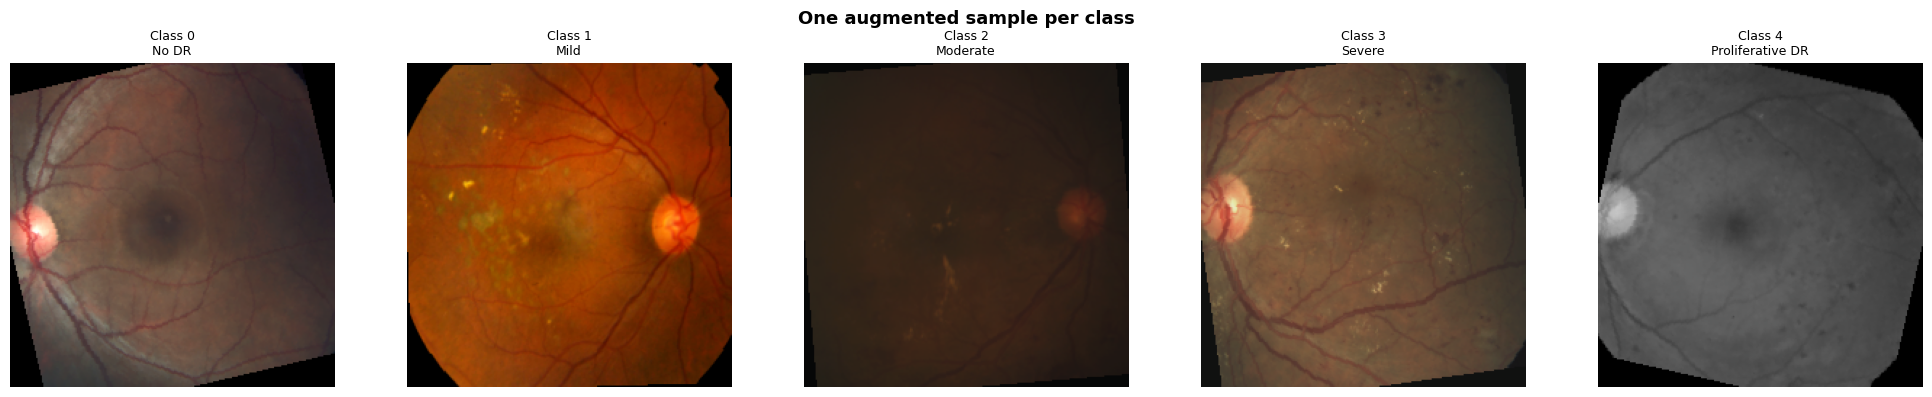

In [8]:
def imshow(img_tensor):
    img = img_tensor.numpy().transpose((1, 2, 0))
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')

# Show one augmented sample per class
fig, axes = plt.subplots(1, NUM_CLASSES, figsize=(4 * NUM_CLASSES, 4))
for cls_idx in range(NUM_CLASSES):
    subset    = train_df[train_df['diagnosis'] == cls_idx]
    first_row = subset.iloc[0]
    path      = Path(IMAGE_DIR) / first_row[IMG_COL]   # IMG_COL detected in Cell 4

    img_pil = Image.open(path).convert('RGB')
    img_t   = train_transforms(img_pil)

    ax = axes[cls_idx]
    plt.sca(ax)
    imshow(img_t)
    ax.set_title(f"Class {cls_idx}\n{CLASS_NAMES[cls_idx]}", fontsize=9)

plt.suptitle("One augmented sample per class", fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()


In [9]:
def print_model_parameters(model, model_name="Model"):
    total_params     = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"\n--- {model_name} Parameters ---")
    print(f"Total Parameters:     {total_params:,}")
    print(f"Trainable Parameters: {trainable_params:,}")
    print("---------------------------------")


## Model Definitions: Student and Teacher Models

In [10]:
def get_student_model(num_classes=5, pretrained=True):
    """
    MobileNetV3-Small (Student) with a replaced classification head.
    """
    try:
        weights = models.MobileNet_V3_Small_Weights.IMAGENET1K_V1 if pretrained else None
        model   = models.mobilenet_v3_small(weights=weights)
    except Exception as e:
        print('Warning: could not load MobileNetV3-Small pretrained weights:', e)
        model = models.mobilenet_v3_small(weights=None)

    in_features = model.classifier[-1].in_features
    model.classifier[-1] = nn.Linear(in_features, num_classes)
    return model


def get_teacher_resnet50(num_classes=5, pretrained=True):
    """
    ResNet50 (Teacher 1) with a replaced classification head.
    """
    try:
        weights = models.ResNet50_Weights.IMAGENET1K_V1 if pretrained else None
        model   = models.resnet50(weights=weights)
    except Exception as e:
        print('Warning: could not load ResNet50 pretrained weights:', e)
        model = models.resnet50(weights=None)
    
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    return model


def get_teacher_efficientnet_b3(num_classes=5, pretrained=True):
    """
    EfficientNet-B3 (Teacher 2) with a replaced classification head.
    """
    try:
        weights = models.EfficientNet_B3_Weights.IMAGENET1K_V1 if pretrained else None
        model   = models.efficientnet_b3(weights=weights)
    except Exception as e:
        print('Warning: could not load EfficientNet-B3 pretrained weights:', e)
        model = models.efficientnet_b3(weights=None)
    
    in_features = model.classifier[-1].in_features
    model.classifier[-1] = nn.Linear(in_features, num_classes)
    return model


## Multi-Teacher Knowledge Distillation Training

Knowledge distillation combines:
1. **Hard Label Loss**: Standard cross-entropy with true labels
2. **Soft Label Loss (KD Loss)**: KL divergence between student and teacher soft predictions
3. **Multi-Teacher**: Average the soft predictions from both teachers

The total loss is: `Loss = α * Hard_Loss + (1-α) * KD_Loss`

Where KD_Loss uses temperature-scaled softmax for smoother probability distributions.

In [11]:
def distillation_loss(student_logits, teacher_logits_list, labels, temperature=4.0, alpha=0.7):
    """
    Multi-teacher knowledge distillation loss.
    
    Args:
        student_logits: Logits from student model [batch_size, num_classes]
        teacher_logits_list: List of logits from teacher models, each [batch_size, num_classes]
        labels: True labels [batch_size]
        temperature: Temperature for softening probability distributions (default: 4.0)
        alpha: Weight for hard label loss vs distillation loss (default: 0.7)
               Loss = alpha * hard_loss + (1-alpha) * distillation_loss
    
    Returns:
        Combined loss value
    """
    # Hard label loss (standard cross-entropy)
    hard_loss = F.cross_entropy(student_logits, labels)
    
    # Soft label loss (knowledge distillation from teachers)
    # Average the predictions from multiple teachers
    teacher_probs_list = [F.softmax(teacher_logits / temperature, dim=1) 
                          for teacher_logits in teacher_logits_list]
    
    # Average teacher probabilities
    avg_teacher_probs = torch.stack(teacher_probs_list).mean(dim=0)
    
    # Student predictions with temperature scaling
    student_log_probs = F.log_softmax(student_logits / temperature, dim=1)
    
    # KL divergence loss (scaled by temperature^2 to maintain gradient magnitude)
    soft_loss = F.kl_div(student_log_probs, avg_teacher_probs, reduction='batchmean') * (temperature ** 2)
    
    # Combined loss
    total_loss = alpha * hard_loss + (1 - alpha) * soft_loss
    
    return total_loss, hard_loss.item(), soft_loss.item()


In [12]:
def train_teacher(model, model_name, train_loader, val_loader, device,
                  epochs=30, lr=1e-3, save_path='./teacher.pth'):
    """
    Train a teacher model using standard supervised learning.
    """
    print(f"\n{'='*70}")
    print(f"Training Teacher: {model_name}")
    print(f"{'='*70}")
    
    model = model.to(device)
    
    # Class weights for imbalanced dataset
    labels_all = train_loader.dataset.df['diagnosis'].values
    counts     = np.bincount(labels_all, minlength=NUM_CLASSES).astype(np.float32)
    weights    = 1.0 / (counts + 1e-6)
    weights    = weights / weights.sum() * NUM_CLASSES
    weights    = torch.tensor(weights, dtype=torch.float32).to(device)
    
    criterion  = nn.CrossEntropyLoss(weight=weights)
    optimizer  = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler  = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    scaler     = GradScaler()
    
    best_val_acc = 0.0
    
    for epoch in range(epochs):
        # TRAIN
        model.train()
        run_loss, total, correct = 0.0, 0, 0
        
        for batch_idx, (imgs, labels) in enumerate(train_loader):
            imgs, labels = imgs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            optimizer.zero_grad()
            
            with autocast():
                outs = model(imgs)
                loss = criterion(outs, labels)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            run_loss += loss.item()
            _, preds = torch.max(outs, 1)
            total    += labels.size(0)
            correct  += preds.eq(labels).sum().item()
            
            if batch_idx % 20 == 0:
                del imgs, labels, outs
                cleanup_memory()
        
        scheduler.step()
        
        avg_train_loss = run_loss / max(1, len(train_loader))
        train_acc      = 100.0 * correct / total if total > 0 else 0.0
        
        # VALIDATION
        model.eval()
        val_loss, total, correct = 0.0, 0, 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
                with autocast():
                    outs = model(imgs)
                    loss = criterion(outs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outs, 1)
                total    += labels.size(0)
                correct  += preds.eq(labels).sum().item()
                del imgs, labels, outs
        
        avg_val_loss = val_loss / max(1, len(val_loader))
        val_acc      = 100.0 * correct / total if total > 0 else 0.0
        
        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f"Epoch {epoch+1:>3}/{epochs} | "
                  f"Train Loss: {avg_train_loss:.4f}  Acc: {train_acc:.2f}% | "
                  f"Val Loss: {avg_val_loss:.4f}  Acc: {val_acc:.2f}%")
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), save_path)
        
        cleanup_memory()
    
    # Reload best weights
    model.load_state_dict(torch.load(save_path, map_location=device))
    model.eval()
    print(f"\nBest validation accuracy: {best_val_acc:.2f}%")
    print(f"Teacher '{model_name}' training completed.\n")
    
    return model, best_val_acc


In [13]:
def train_student_with_distillation(student, teachers, train_loader, val_loader, device,
                                     epochs=50, lr=1e-3, temperature=4.0, alpha=0.7,
                                     save_path='./best_student.pth'):
    """
    Train student model using multi-teacher knowledge distillation.
    
    Args:
        student: Student model (MobileNetV3-Small)
        teachers: List of teacher models (ResNet50, EfficientNet-B3)
        temperature: Temperature for distillation (higher = softer distributions)
        alpha: Weight for hard loss (1-alpha for soft loss)
    """
    print(f"\n{'='*70}")
    print(f"Training Student with Multi-Teacher Distillation")
    print(f"Temperature: {temperature} | Alpha (hard loss weight): {alpha}")
    print(f"{'='*70}")
    
    student = student.to(device)
    for teacher in teachers:
        teacher.to(device)
        teacher.eval()  # Teachers are frozen during distillation
    
    optimizer  = torch.optim.AdamW(student.parameters(), lr=lr, weight_decay=1e-4)
    scheduler  = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    scaler     = GradScaler()
    
    best_val_acc = 0.0
    history = {
        'train_loss': [], 'train_hard_loss': [], 'train_soft_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }
    
    for epoch in range(epochs):
        # TRAIN
        student.train()
        run_loss, run_hard_loss, run_soft_loss = 0.0, 0.0, 0.0
        total, correct = 0, 0
        
        for batch_idx, (imgs, labels) in enumerate(train_loader):
            imgs, labels = imgs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            optimizer.zero_grad()
            
            with autocast():
                # Student forward pass
                student_logits = student(imgs)
                
                # Teacher forward passes (no gradients needed)
                with torch.no_grad():
                    teacher_logits_list = [teacher(imgs) for teacher in teachers]
                
                # Compute distillation loss
                loss, hard_loss, soft_loss = distillation_loss(
                    student_logits, teacher_logits_list, labels,
                    temperature=temperature, alpha=alpha
                )
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            run_loss += loss.item()
            run_hard_loss += hard_loss
            run_soft_loss += soft_loss
            
            _, preds = torch.max(student_logits, 1)
            total    += labels.size(0)
            correct  += preds.eq(labels).sum().item()
            
            if batch_idx % 20 == 0:
                del imgs, labels, student_logits, teacher_logits_list
                cleanup_memory()
        
        scheduler.step()
        
        avg_train_loss = run_loss / max(1, len(train_loader))
        avg_hard_loss = run_hard_loss / max(1, len(train_loader))
        avg_soft_loss = run_soft_loss / max(1, len(train_loader))
        train_acc     = 100.0 * correct / total if total > 0 else 0.0
        
        # VALIDATION (no distillation, just standard evaluation)
        student.eval()
        val_loss, total, correct = 0.0, 0, 0
        criterion = nn.CrossEntropyLoss()
        
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
                with autocast():
                    outs = student(imgs)
                    loss = criterion(outs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outs, 1)
                total    += labels.size(0)
                correct  += preds.eq(labels).sum().item()
                del imgs, labels, outs
        
        avg_val_loss = val_loss / max(1, len(val_loader))
        val_acc      = 100.0 * correct / total if total > 0 else 0.0
        
        # Store history
        history['train_loss'].append(avg_train_loss)
        history['train_hard_loss'].append(avg_hard_loss)
        history['train_soft_loss'].append(avg_soft_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_acc)
        
        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f"Epoch {epoch+1:>3}/{epochs} | "
                  f"Train Loss: {avg_train_loss:.4f} (Hard: {avg_hard_loss:.4f}, Soft: {avg_soft_loss:.4f}) "
                  f"Acc: {train_acc:.2f}% | Val Loss: {avg_val_loss:.4f}  Acc: {val_acc:.2f}%")
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(student.state_dict(), save_path)
        
        cleanup_memory()
    
    # Reload best weights
    student.load_state_dict(torch.load(save_path, map_location=device))
    student.eval()
    print(f"\nBest validation accuracy: {best_val_acc:.2f}%")
    
    return student, best_val_acc, history


## Main Experiment Loop

In [14]:
def run_distillation_experiment():
    """
    Multi-teacher knowledge distillation experiment:
    1. Train teacher models (ResNet50, EfficientNet-B3)
    2. Train student (MobileNetV3-Small) using knowledge distillation
    3. Run multiple seeds for reproducibility
    """
    seeds = [3, 8, 5]
    TEACHER_EPOCHS = 30
    STUDENT_EPOCHS = 50
    TEMPERATURE = 4.0
    ALPHA = 0.7  # Weight for hard loss
    
    all_results = {
        'test_accs':             [],
        'val_accuracies':        [],
        'train_losses':          [],
        'train_hard_losses':     [],
        'train_soft_losses':     [],
        'train_accs':            [],
        'val_losses':            [],
        'classification_reports': [],
        'confusion_matrices':    [],
        'y_true_all':            [],
        'y_pred_all':            [],
        'teacher_accs':          {'resnet50': [], 'efficientnet_b3': []}
    }
    
    print("="*80)
    print("Multi-Teacher Knowledge Distillation Experiment")
    print("Student: MobileNetV3-Small | Teachers: ResNet50 + EfficientNet-B3")
    print(f"Train: {len(train_ds)}  |  Val: {len(val_ds)}  |  Test: {len(test_ds)}")
    print(f"Classes: {CLASS_NAMES}")
    print(f"Batch size: {BATCH_SIZE} | Teacher epochs: {TEACHER_EPOCHS} | Student epochs: {STUDENT_EPOCHS}")
    print(f"Distillation - Temperature: {TEMPERATURE}, Alpha: {ALPHA}")
    print("="*80)
    
    for run_idx, seed in enumerate(seeds):
        print(f"\n{'='*70}")
        print(f"RUN {run_idx + 1}/3  –  Seed: {seed}")
        print(f"{'='*70}")
        
        set_seed(seed)
        cleanup_memory()
        
        # ─── STEP 1: Train Teachers ───
        print("\n" + "─"*70)
        print("PHASE 1: Training Teacher Models")
        print("─"*70)
        
        # Teacher 1: ResNet50
        teacher1 = get_teacher_resnet50(num_classes=NUM_CLASSES, pretrained=True).to(device)
        if run_idx == 0:
            print_model_parameters(teacher1, "ResNet50 (Teacher 1)")
        
        teacher1, teacher1_acc = train_teacher(
            teacher1, "ResNet50", train_loader, val_loader, device,
            epochs=TEACHER_EPOCHS, lr=1e-3,
            save_path=f'./teacher_resnet50_seed{seed}.pth'
        )
        all_results['teacher_accs']['resnet50'].append(teacher1_acc)
        
        # Teacher 2: EfficientNet-B3
        teacher2 = get_teacher_efficientnet_b3(num_classes=NUM_CLASSES, pretrained=True).to(device)
        if run_idx == 0:
            print_model_parameters(teacher2, "EfficientNet-B3 (Teacher 2)")
        
        teacher2, teacher2_acc = train_teacher(
            teacher2, "EfficientNet-B3", train_loader, val_loader, device,
            epochs=TEACHER_EPOCHS, lr=1e-3,
            save_path=f'./teacher_efficientnet_b3_seed{seed}.pth'
        )
        all_results['teacher_accs']['efficientnet_b3'].append(teacher2_acc)
        
        print(f"\nTeacher validation accuracies:")
        print(f"  ResNet50: {teacher1_acc:.2f}%")
        print(f"  EfficientNet-B3: {teacher2_acc:.2f}%")
        
        # ─── STEP 2: Train Student with Distillation ───
        print("\n" + "─"*70)
        print("PHASE 2: Training Student with Multi-Teacher Distillation")
        print("─"*70)
        
        student = get_student_model(num_classes=NUM_CLASSES, pretrained=True)
        if run_idx == 0:
            print_model_parameters(student, "MobileNetV3-Small (Student)")
        
        student, best_val_acc, history = train_student_with_distillation(
            student, [teacher1, teacher2], train_loader, val_loader, device,
            epochs=STUDENT_EPOCHS, lr=1e-3,
            temperature=TEMPERATURE, alpha=ALPHA,
            save_path=f'./student_mobilenetv3_seed{seed}.pth'
        )
        
        all_results['val_accuracies'].append(history['val_acc'])
        all_results['train_losses'].append(history['train_loss'])
        all_results['train_hard_losses'].append(history['train_hard_loss'])
        all_results['train_soft_losses'].append(history['train_soft_loss'])
        all_results['train_accs'].append(history['train_acc'])
        all_results['val_losses'].append(history['val_loss'])
        
        # ─── STEP 3: Test Student ───
        print("\nEvaluating student on test set…")
        student.eval()
        y_true, y_pred = [], []
        with torch.no_grad():
            for imgs, labels in test_loader:
                imgs = imgs.to(device)
                outs = student(imgs)
                _, preds = torch.max(outs, 1)
                y_true.extend(labels.numpy())
                y_pred.extend(preds.cpu().numpy())
                del imgs, outs
        
        test_acc = 100.0 * np.mean(np.array(y_true) == np.array(y_pred))
        print(f"Student test accuracy (Run {run_idx + 1}): {test_acc:.2f}%")
        all_results['test_accs'].append(test_acc)
        all_results['y_true_all'].append(y_true)
        all_results['y_pred_all'].append(y_pred)
        
        report = classification_report(y_true, y_pred,
                                       target_names=CLASS_NAMES,
                                       output_dict=True, zero_division=0)
        all_results['classification_reports'].append(report)
        all_results['confusion_matrices'].append(confusion_matrix(y_true, y_pred, labels=range(NUM_CLASSES)))
        
        # Cleanup
        del teacher1, teacher2, student
        cleanup_memory()
        print(f"\nRun {run_idx + 1} completed. Memory cleaned.")
    
    # ─────────────────────── RESULTS ───────────────────────
    print(f"\n{'='*80}")
    print("FINAL RESULTS  –  AVERAGED ACROSS 3 RUNS")
    print(f"{'='*80}")
    
    # Teacher results
    print("\nTEACHER MODEL PERFORMANCE:")
    resnet_accs = np.array(all_results['teacher_accs']['resnet50'])
    effnet_accs = np.array(all_results['teacher_accs']['efficientnet_b3'])
    print(f"  ResNet50:")
    print(f"    Mean: {np.mean(resnet_accs):.2f}% ± {np.std(resnet_accs):.2f}%")
    print(f"  EfficientNet-B3:")
    print(f"    Mean: {np.mean(effnet_accs):.2f}% ± {np.std(effnet_accs):.2f}%")
    
    # Student test results
    test_accs = np.array(all_results['test_accs'])
    print(f"\nSTUDENT TEST ACCURACY:")
    print(f"  Individual : {test_accs}")
    print(f"  Mean       : {np.mean(test_accs):.2f}% ± {np.std(test_accs):.2f}%")
    print(f"  Best       : {np.max(test_accs):.2f}%")
    print(f"  Worst      : {np.min(test_accs):.2f}%")
    
    # Averaged curves
    avg_val_acc    = np.mean(all_results['val_accuracies'], axis=0)
    std_val_acc    = np.std(all_results['val_accuracies'], axis=0)
    avg_train_loss = np.mean(all_results['train_losses'], axis=0)
    avg_hard_loss  = np.mean(all_results['train_hard_losses'], axis=0)
    avg_soft_loss  = np.mean(all_results['train_soft_losses'], axis=0)
    avg_val_loss   = np.mean(all_results['val_losses'], axis=0)
    avg_train_acc  = np.mean(all_results['train_accs'], axis=0)
    
    # Confusion matrix stats
    avg_cm      = np.mean(all_results['confusion_matrices'], axis=0)
    std_cm      = np.std(all_results['confusion_matrices'], axis=0)
    avg_cm_norm = avg_cm / avg_cm.sum(axis=1, keepdims=True)
    
    print("\nAVERAGE CONFUSION MATRIX (Normalized):")
    print(f"{'':>16}", end="")
    for cn in CLASS_NAMES:
        print(f"{cn:>16}", end="")
    print()
    for i, cn in enumerate(CLASS_NAMES):
        print(f"{cn:>16}", end="")
        for j in range(NUM_CLASSES):
            print(f"{avg_cm_norm[i,j]:>16.3f}", end="")
        print()
    
    class_accs = [avg_cm_norm[i, i] * 100 for i in range(NUM_CLASSES)]
    print("\nPER-CLASS ACCURACY:")
    for i, cn in enumerate(CLASS_NAMES):
        support = int(avg_cm[i].sum())
        print(f"  {cn:>20}: {class_accs[i]:>6.2f}%   (avg support {support})")
    
    best_cls  = int(np.argmax(class_accs))
    worst_cls = int(np.argmin(class_accs))
    print(f"\n  Best  : {CLASS_NAMES[best_cls]}  ({class_accs[best_cls]:.2f}%)")
    print(f"  Worst : {CLASS_NAMES[worst_cls]}  ({class_accs[worst_cls]:.2f}%)")
    
    # Top misclassifications
    print("\nTOP MISCLASSIFICATIONS:")
    miscs = []
    for i in range(NUM_CLASSES):
        for j in range(NUM_CLASSES):
            if i != j:
                miscs.append((avg_cm[i, j], i, j))
    miscs.sort(reverse=True)
    for k, (freq, ti, pi) in enumerate(miscs[:5]):
        pct = (freq / avg_cm[ti].sum()) * 100 if avg_cm[ti].sum() > 0 else 0
        print(f"  {k+1}. {CLASS_NAMES[ti]:>20} → {CLASS_NAMES[pi]:<20}: "
              f"{freq:>6.1f} cases  ({pct:.1f}% of {CLASS_NAMES[ti]})")
    
    # ─────────────────── VISUALIZATION ─────────────────────
    fig = plt.figure(figsize=(24, 18))
    gs = fig.add_gridspec(4, 4, hspace=0.3, wspace=0.3)
    
    fig.suptitle("Multi-Teacher Knowledge Distillation – MobileNetV3-Small Student",
                 fontsize=16, fontweight='bold', y=0.995)
    
    # Row 1: Performance comparisons
    # 1. Test accuracy comparison (teachers vs student)
    ax = fig.add_subplot(gs[0, 0])
    positions = [1, 2, 3]
    box_data = [resnet_accs, effnet_accs, test_accs]
    bp = ax.boxplot(box_data, positions=positions, widths=0.6,
                    patch_artist=True, showmeans=True)
    colors = ['#ff9999', '#99ccff', '#99ff99']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    ax.set_xticklabels(['ResNet50\n(Teacher)', 'EfficientNet-B3\n(Teacher)', 'MobileNetV3\n(Student)'],
                       fontsize=9)
    ax.set_ylabel('Validation Accuracy (%)', fontsize=10)
    ax.set_title('Teacher vs Student Performance', fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    
    # 2. Train vs Val accuracy
    ax = fig.add_subplot(gs[0, 1])
    epochs_range = range(len(avg_val_acc))
    ax.plot(epochs_range, avg_train_acc, 'b-', linewidth=2, label='Train', alpha=0.7)
    ax.plot(epochs_range, avg_val_acc, 'o-', color='orange', linewidth=2, 
            markersize=0, label='Val (mean)')
    ax.fill_between(epochs_range,
                    avg_val_acc - std_val_acc,
                    avg_val_acc + std_val_acc,
                    alpha=0.25, color='orange', label='Val ± 1σ')
    ax.set_title('Student Accuracy Curves', fontsize=11, fontweight='bold')
    ax.set_xlabel('Epoch', fontsize=10)
    ax.set_ylabel('Accuracy (%)', fontsize=10)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    
    # 3. Loss decomposition (hard vs soft)
    ax = fig.add_subplot(gs[0, 2])
    ax.plot(avg_train_loss, 'k-', linewidth=2.5, label='Total Loss', alpha=0.8)
    ax.plot(avg_hard_loss, 'r--', linewidth=1.5, label='Hard Loss (CE)', alpha=0.7)
    ax.plot(avg_soft_loss, 'b--', linewidth=1.5, label='Soft Loss (KD)', alpha=0.7)
    ax.set_title('Loss Decomposition (Student)', fontsize=11, fontweight='bold')
    ax.set_xlabel('Epoch', fontsize=10)
    ax.set_ylabel('Loss', fontsize=10)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    
    # 4. Individual val-acc runs
    ax = fig.add_subplot(gs[0, 3])
    colors_run = ['#e6194b', '#3cb44b', '#4363d8']
    for i, va in enumerate(all_results['val_accuracies']):
        ax.plot(va, color=colors_run[i], alpha=0.7, linewidth=1.5, label=f'Run {i+1}')
    ax.plot(avg_val_acc, 'k-', linewidth=2.5, label='Mean')
    ax.set_title('Individual Student Val-Acc Runs', fontsize=11, fontweight='bold')
    ax.set_xlabel('Epoch', fontsize=10)
    ax.set_ylabel('Val Accuracy (%)', fontsize=10)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    
    # Row 2: Confusion matrices
    # 5. Average CM (raw)
    ax = fig.add_subplot(gs[1, 0])
    disp = ConfusionMatrixDisplay(confusion_matrix=avg_cm.astype(int),
                                  display_labels=CLASS_NAMES)
    disp.plot(ax=ax, cmap='Blues', values_format='d')
    ax.set_title('Avg CM (Raw Counts)', fontsize=11, fontweight='bold')
    ax.tick_params(axis='x', rotation=30, labelsize=8)
    ax.tick_params(axis='y', labelsize=8)
    
    # 6. Average CM (normalized)
    ax = fig.add_subplot(gs[1, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=avg_cm_norm,
                                  display_labels=CLASS_NAMES)
    disp.plot(ax=ax, cmap='Blues', values_format='.2f')
    ax.set_title('Avg CM (Normalized)', fontsize=11, fontweight='bold')
    ax.tick_params(axis='x', rotation=30, labelsize=8)
    ax.tick_params(axis='y', labelsize=8)
    
    # 7. CM std-dev
    ax = fig.add_subplot(gs[1, 2])
    disp = ConfusionMatrixDisplay(confusion_matrix=std_cm,
                                  display_labels=CLASS_NAMES)
    disp.plot(ax=ax, cmap='Reds', values_format='.1f')
    ax.set_title('CM Std Dev across runs', fontsize=11, fontweight='bold')
    ax.tick_params(axis='x', rotation=30, labelsize=8)
    ax.tick_params(axis='y', labelsize=8)
    
    # 8. Best-run CM
    best_run = int(np.argmax(test_accs))
    ax = fig.add_subplot(gs[1, 3])
    disp = ConfusionMatrixDisplay(confusion_matrix=all_results['confusion_matrices'][best_run],
                                  display_labels=CLASS_NAMES)
    disp.plot(ax=ax, cmap='Greens', values_format='d')
    ax.set_title(f'Best Run CM (Run {best_run+1}: {test_accs[best_run]:.1f}%)',
                fontsize=11, fontweight='bold')
    ax.tick_params(axis='x', rotation=30, labelsize=8)
    ax.tick_params(axis='y', labelsize=8)
    
    # Row 3: Per-class metrics
    # 9. Per-class accuracy
    ax = fig.add_subplot(gs[2, 0])
    bar_colors = ['green' if i == best_cls else 'red' if i == worst_cls else 'steelblue'
                  for i in range(NUM_CLASSES)]
    bars = ax.bar(range(NUM_CLASSES), class_accs, color=bar_colors, alpha=0.8)
    ax.set_xticks(range(NUM_CLASSES))
    ax.set_xticklabels(CLASS_NAMES, rotation=30, ha='right', fontsize=9)
    ax.set_title('Per-Class Accuracy', fontsize=11, fontweight='bold')
    ax.set_ylabel('Accuracy (%)', fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')
    for b, v in zip(bars, class_accs):
        ax.text(b.get_x() + b.get_width()/2, b.get_height() + 1,
                f'{v:.1f}%', ha='center', va='bottom', fontsize=8)
    
    # 10. Per-class F1
    ax = fig.add_subplot(gs[2, 1])
    f1_matrix = []
    for rep in all_results['classification_reports']:
        f1_matrix.append([rep[cn]['f1-score'] for cn in CLASS_NAMES])
    avg_f1 = np.mean(f1_matrix, axis=0) * 100
    std_f1 = np.std(f1_matrix, axis=0) * 100
    ax.bar(range(NUM_CLASSES), avg_f1, yerr=std_f1, capsize=4,
           color='mediumpurple', alpha=0.8)
    ax.set_xticks(range(NUM_CLASSES))
    ax.set_xticklabels(CLASS_NAMES, rotation=30, ha='right', fontsize=9)
    ax.set_title('Per-Class F1-Score', fontsize=11, fontweight='bold')
    ax.set_ylabel('F1 (%)', fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')
    
    # 11. Precision & Recall
    ax = fig.add_subplot(gs[2, 2])
    prec_matrix, rec_matrix = [], []
    for rep in all_results['classification_reports']:
        prec_matrix.append([rep[cn]['precision'] for cn in CLASS_NAMES])
        rec_matrix.append([rep[cn]['recall'] for cn in CLASS_NAMES])
    avg_prec = np.mean(prec_matrix, axis=0) * 100
    avg_rec  = np.mean(rec_matrix, axis=0) * 100
    x = np.arange(NUM_CLASSES)
    w = 0.35
    ax.bar(x - w/2, avg_prec, w, color='cornflowerblue', label='Precision', alpha=0.8)
    ax.bar(x + w/2, avg_rec,  w, color='salmon', label='Recall', alpha=0.8)
    ax.set_xticks(x)
    ax.set_xticklabels(CLASS_NAMES, rotation=30, ha='right', fontsize=9)
    ax.set_title('Precision & Recall', fontsize=11, fontweight='bold')
    ax.set_ylabel('%', fontsize=10)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3, axis='y')
    
    # 12. Class distribution
    ax = fig.add_subplot(gs[2, 3])
    class_counts = [int((train_df['diagnosis'] == i).sum()) for i in range(NUM_CLASSES)]
    ax.bar(range(NUM_CLASSES), class_counts, color='darkgoldenrod', alpha=0.8)
    ax.set_xticks(range(NUM_CLASSES))
    ax.set_xticklabels(CLASS_NAMES, rotation=30, ha='right', fontsize=9)
    ax.set_title('Train Set Class Distribution', fontsize=11, fontweight='bold')
    ax.set_ylabel('Count', fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Row 4: Additional insights
    # 13. Train loss over time
    ax = fig.add_subplot(gs[3, 0])
    ax.plot(avg_train_loss, 'b-', linewidth=2, label='Train Loss')
    ax.plot(avg_val_loss, 'r-', linewidth=2, label='Val Loss')
    ax.set_title('Student Loss Curves', fontsize=11, fontweight='bold')
    ax.set_xlabel('Epoch', fontsize=10)
    ax.set_ylabel('Loss', fontsize=10)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    
    # 14. Hard loss contribution over epochs
    ax = fig.add_subplot(gs[3, 1])
    hard_contribution = (avg_hard_loss * ALPHA) / avg_train_loss * 100
    soft_contribution = (avg_soft_loss * (1-ALPHA)) / avg_train_loss * 100
    ax.plot(hard_contribution, 'r-', linewidth=2, label=f'Hard Loss ({ALPHA*100:.0f}%)')
    ax.plot(soft_contribution, 'b-', linewidth=2, label=f'Soft Loss ({(1-ALPHA)*100:.0f}%)')
    ax.set_title('Loss Component Contributions', fontsize=11, fontweight='bold')
    ax.set_xlabel('Epoch', fontsize=10)
    ax.set_ylabel('% of Total Loss', fontsize=10)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    
    # 15. Teacher agreement analysis
    ax = fig.add_subplot(gs[3, 2])
    teacher_comparison = pd.DataFrame({
        'ResNet50': resnet_accs,
        'EfficientNet-B3': effnet_accs,
        'Student': test_accs
    })
    teacher_comparison.plot(kind='bar', ax=ax, width=0.7)
    ax.set_xticklabels([f'Run {i+1}' for i in range(len(seeds))], rotation=0, fontsize=9)
    ax.set_title('Teacher & Student Performance by Run', fontsize=11, fontweight='bold')
    ax.set_ylabel('Test/Val Accuracy (%)', fontsize=10)
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3, axis='y')
    
    # 16. Summary stats text
    ax = fig.add_subplot(gs[3, 3])
    ax.axis('off')
    summary_text = f"""
EXPERIMENT SUMMARY
{'─'*30}

Configuration:
  • Temperature: {TEMPERATURE}
  • Alpha (Hard/Soft): {ALPHA}/{1-ALPHA}
  • Student Epochs: {STUDENT_EPOCHS}
  • Teacher Epochs: {TEACHER_EPOCHS}

Teacher Performance:
  • ResNet50: {np.mean(resnet_accs):.2f}% ± {np.std(resnet_accs):.2f}%
  • EfficientNet-B3: {np.mean(effnet_accs):.2f}% ± {np.std(effnet_accs):.2f}%

Student Performance:
  • Mean Test Acc: {np.mean(test_accs):.2f}% ± {np.std(test_accs):.2f}%
  • Best: {np.max(test_accs):.2f}%
  • Worst: {np.min(test_accs):.2f}%

Per-Class (Student):
  • Best: {CLASS_NAMES[best_cls]} ({class_accs[best_cls]:.1f}%)
  • Worst: {CLASS_NAMES[worst_cls]} ({class_accs[worst_cls]:.1f}%)
  • Avg: {np.mean(class_accs):.2f}%
  • Range: {np.max(class_accs)-np.min(class_accs):.1f}%
    """
    ax.text(0.05, 0.95, summary_text, transform=ax.transAxes,
            fontsize=9, verticalalignment='top', family='monospace',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
    
    plt.show()
    
    # ─── Summary print ───
    print(f"\n{'='*80}")
    print("PERFORMANCE SUMMARY")
    print(f"{'='*80}")
    print(f"Teacher Ensemble Avg            : {(np.mean(resnet_accs) + np.mean(effnet_accs))/2:.2f}%")
    print(f"Student Test Acc (Mean)         : {np.mean(test_accs):.2f}% ± {np.std(test_accs):.2f}%")
    print(f"Consistency (Test Acc Std)      : {np.std(test_accs):.2f}%")
    print(f"Average Per-Class Accuracy      : {np.mean(class_accs):.2f}%")
    print(f"Class Performance Range         : {np.min(class_accs):.2f}% – {np.max(class_accs):.2f}%")
    print(f"Class Accuracy Std Dev          : {np.std(class_accs):.2f}%")
    
    return {
        'mean_test_acc': np.mean(test_accs),
        'std_test_acc':  np.std(test_accs),
        'teacher_accs': {
            'resnet50': np.mean(resnet_accs),
            'efficientnet_b3': np.mean(effnet_accs)
        },
        'avg_training_curves': {
            'val_acc':      avg_val_acc,
            'train_loss':   avg_train_loss,
            'hard_loss':    avg_hard_loss,
            'soft_loss':    avg_soft_loss,
            'val_loss':     avg_val_loss,
            'train_acc':    avg_train_acc
        },
        'confusion_matrix_analysis': {
            'avg_cm':           avg_cm,
            'std_cm':           std_cm,
            'avg_cm_norm':      avg_cm_norm,
            'per_class_accs':   class_accs,
            'best_class':       CLASS_NAMES[best_cls],
            'worst_class':      CLASS_NAMES[worst_cls],
            'top_misclasses':   miscs[:5]
        },
        'individual_results': all_results
    }


In [ ]:
if __name__ == "__main__":
    os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
    
    results = run_distillation_experiment()
    print("\nExperiment completed.")
    print(f"Final student test accuracy: {results['mean_test_acc']:.2f}% ± {results['std_test_acc']:.2f}%")
    print(f"Teacher ensemble average: {(results['teacher_accs']['resnet50'] + results['teacher_accs']['efficientnet_b3'])/2:.2f}%")


Multi-Teacher Knowledge Distillation Experiment
Student: MobileNetV3-Small | Teachers: ResNet50 + EfficientNet-B3
Train: 2563  |  Val: 549  |  Test: 550
Classes: ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR']
Batch size: 18 | Teacher epochs: 30 | Student epochs: 50
Distillation - Temperature: 4.0, Alpha: 0.7

RUN 1/3  –  Seed: 3

──────────────────────────────────────────────────────────────────────
PHASE 1: Training Teacher Models
──────────────────────────────────────────────────────────────────────
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 171MB/s]



--- ResNet50 (Teacher 1) Parameters ---
Total Parameters:     23,518,277
Trainable Parameters: 23,518,277
---------------------------------

Training Teacher: ResNet50


/tmp/ipykernel_101/2345534249.py:22: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler     = GradScaler()
/tmp/ipykernel_101/2345534249.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_101/2345534249.py:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch   1/30 | Train Loss: 1.5736  Acc: 37.81% | Val Loss: 1.4679  Acc: 27.14%
Epoch   5/30 | Train Loss: 1.2272  Acc: 59.23% | Val Loss: 1.1847  Acc: 55.19%
Epoch  10/30 | Train Loss: 1.0657  Acc: 65.98% | Val Loss: 1.1259  Acc: 65.57%
Epoch  15/30 | Train Loss: 0.9442  Acc: 69.96% | Val Loss: 1.0364  Acc: 66.85%
Epoch  20/30 | Train Loss: 0.8580  Acc: 74.60% | Val Loss: 0.9989  Acc: 69.95%
Epoch  25/30 | Train Loss: 0.7855  Acc: 76.51% | Val Loss: 0.9806  Acc: 74.32%
Epoch  30/30 | Train Loss: 0.7614  Acc: 78.19% | Val Loss: 0.9965  Acc: 72.86%

Best validation accuracy: 74.50%
Teacher 'ResNet50' training completed.

Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth


100%|██████████| 47.2M/47.2M [00:00<00:00, 183MB/s]



--- EfficientNet-B3 (Teacher 2) Parameters ---
Total Parameters:     10,703,917
Trainable Parameters: 10,703,917
---------------------------------

Training Teacher: EfficientNet-B3
Epoch   1/30 | Train Loss: 1.1557  Acc: 62.08% | Val Loss: 0.9838  Acc: 69.03%
Epoch   5/30 | Train Loss: 0.8290  Acc: 77.25% | Val Loss: 0.8408  Acc: 75.96%
Epoch  10/30 | Train Loss: 0.6742  Acc: 80.37% | Val Loss: 1.1464  Acc: 71.77%
Epoch  15/30 | Train Loss: 0.4815  Acc: 85.49% | Val Loss: 0.9200  Acc: 77.60%
Epoch  20/30 | Train Loss: 0.3411  Acc: 89.74% | Val Loss: 1.2219  Acc: 77.96%
Epoch  25/30 | Train Loss: 0.1674  Acc: 95.51% | Val Loss: 1.4695  Acc: 80.87%
Epoch  30/30 | Train Loss: 0.1321  Acc: 95.94% | Val Loss: 1.4874  Acc: 80.69%

Best validation accuracy: 81.79%
Teacher 'EfficientNet-B3' training completed.


Teacher validation accuracies:
  ResNet50: 74.50%
  EfficientNet-B3: 81.79%

──────────────────────────────────────────────────────────────────────
PHASE 2: Training Student with Mul

100%|██████████| 9.83M/9.83M [00:00<00:00, 133MB/s]


--- MobileNetV3-Small (Student) Parameters ---
Total Parameters:     1,522,981
Trainable Parameters: 1,522,981
---------------------------------

Training Student with Multi-Teacher Distillation
Temperature: 4.0 | Alpha (hard loss weight): 0.7



/tmp/ipykernel_101/479999490.py:25: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler     = GradScaler()
/tmp/ipykernel_101/479999490.py:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_101/479999490.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch   1/50 | Train Loss: 1.0693 (Hard: 0.7476, Soft: 1.8201) Acc: 71.95% | Val Loss: 1.0509  Acc: 71.77%
Epoch   5/50 | Train Loss: 0.5829 (Hard: 0.4790, Soft: 0.8253) Acc: 82.05% | Val Loss: 0.6551  Acc: 75.41%
Epoch  10/50 | Train Loss: 0.4920 (Hard: 0.4020, Soft: 0.7018) Acc: 84.32% | Val Loss: 0.6445  Acc: 77.78%
Epoch  15/50 | Train Loss: 0.3938 (Hard: 0.3200, Soft: 0.5660) Acc: 88.06% | Val Loss: 0.6539  Acc: 77.05%
Epoch  20/50 | Train Loss: 0.3260 (Hard: 0.2588, Soft: 0.4826) Acc: 90.17% | Val Loss: 0.6895  Acc: 76.50%
Epoch  25/50 | Train Loss: 0.2470 (Hard: 0.1802, Soft: 0.4029) Acc: 93.60% | Val Loss: 0.6813  Acc: 78.69%
Epoch  30/50 | Train Loss: 0.2067 (Hard: 0.1398, Soft: 0.3626) Acc: 95.63% | Val Loss: 0.6537  Acc: 80.69%
Epoch  35/50 | Train Loss: 0.1621 (Hard: 0.1046, Soft: 0.2963) Acc: 97.35% | Val Loss: 0.6824  Acc: 78.14%
Epoch  40/50 | Train Loss: 0.1533 (Hard: 0.0966, Soft: 0.2856) Acc: 97.39% | Val Loss: 0.6447  Acc: 79.42%
Epoch  45/50 | Train Loss: 0.1372 (Ha

/tmp/ipykernel_101/2345534249.py:22: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler     = GradScaler()
/tmp/ipykernel_101/2345534249.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_101/2345534249.py:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch   1/30 | Train Loss: 1.6191  Acc: 33.48% | Val Loss: 1.5707  Acc: 37.70%
Epoch   5/30 | Train Loss: 1.2007  Acc: 56.77% | Val Loss: 1.1979  Acc: 61.38%
Epoch  10/30 | Train Loss: 1.0519  Acc: 65.55% | Val Loss: 1.3591  Acc: 62.66%
Epoch  15/30 | Train Loss: 0.9235  Acc: 71.83% | Val Loss: 1.0549  Acc: 68.67%
Epoch  20/30 | Train Loss: 0.8656  Acc: 74.44% | Val Loss: 0.9412  Acc: 71.40%
Epoch  25/30 | Train Loss: 0.8037  Acc: 76.08% | Val Loss: 0.9382  Acc: 70.86%
Epoch  30/30 | Train Loss: 0.7712  Acc: 77.37% | Val Loss: 0.9878  Acc: 70.13%

Best validation accuracy: 72.13%
Teacher 'ResNet50' training completed.


Training Teacher: EfficientNet-B3
Epoch   1/30 | Train Loss: 1.1373  Acc: 64.88% | Val Loss: 1.1150  Acc: 70.31%
Epoch   5/30 | Train Loss: 0.8412  Acc: 75.81% | Val Loss: 1.0797  Acc: 71.77%
Epoch  10/30 | Train Loss: 0.7186  Acc: 79.48% | Val Loss: 0.9708  Acc: 79.23%
Epoch  15/30 | Train Loss: 0.5018  Acc: 85.37% | Val Loss: 1.1004  Acc: 81.24%
Epoch  20/30 | Train L

/tmp/ipykernel_101/479999490.py:25: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler     = GradScaler()
/tmp/ipykernel_101/479999490.py:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_101/479999490.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch   1/50 | Train Loss: 0.9577 (Hard: 0.7551, Soft: 1.4304) Acc: 71.99% | Val Loss: 0.7501  Acc: 74.50%
Epoch   5/50 | Train Loss: 0.4903 (Hard: 0.4676, Soft: 0.5432) Acc: 82.44% | Val Loss: 0.7010  Acc: 73.22%
Epoch  10/50 | Train Loss: 0.4045 (Hard: 0.4025, Soft: 0.4091) Acc: 85.41% | Val Loss: 0.5647  Acc: 81.24%
Epoch  15/50 | Train Loss: 0.3484 (Hard: 0.3375, Soft: 0.3740) Acc: 87.98% | Val Loss: 0.6287  Acc: 77.96%
Epoch  20/50 | Train Loss: 0.3400 (Hard: 0.3091, Soft: 0.4122) Acc: 89.27% | Val Loss: 0.6130  Acc: 78.14%
Epoch  25/50 | Train Loss: 0.2672 (Hard: 0.2455, Soft: 0.3179) Acc: 91.03% | Val Loss: 0.5536  Acc: 78.87%
Epoch  30/50 | Train Loss: 0.2404 (Hard: 0.2075, Soft: 0.3171) Acc: 93.37% | Val Loss: 0.5693  Acc: 80.33%
